# Riesling Challenge

We recently stumbled upon a Riesling tasting box and ended up turning last years drinking challenge into a tradition: We invited a bunch of friends and tried to assign the wines to annonymised descriptions (see [form](./data/riesling_challenge.pdf) in German).

![WTF](data/riesling_challenge.jpg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
riesling_challenge = pd.read_csv('data/riesling_challenge.csv', index_col=0, header=[0, 1])

pd.set_option('display.max_columns', None)
riesling_challenge

Order   Stef  \
                                     Order Rating   
Barth Hattenheimer Schützenhaus 2016     2      3   
Barth Fructus 2017                       5      4   
Stefan Bietighöfer Reserve               1      4   
Julian Haart Mosel Riesling              6      3   
No Sex                                   3      3   
Steinterrassen Reh                       4      4   

                                                                            \
                                                                     Guess   
Barth Hattenheimer Schützenhaus 2016           Julian Haart Mosel Riesling   
Barth Fructus 2017                                                  No Sex   
Stefan Bietighöfer Reserve                              Barth Fructus 2017   
Julian Haart Mosel Riesling                             Steinterrassen Reh   
No Sex                                Barth Hattenheimer Schützenhaus 2016   
Steinterrassen Reh                              Stefan Bietighöfer Reserve   

                                        Ste  \
                                     Rating   
Barth Hattenheimer Schützenhaus 2016      3   
Barth Fructus 2017                        4   
Stefan Bietighöfer Reserve                5   
Julian Haart Mosel Riesling               3   
No Sex                                    4   
Steinterrassen Reh                        3   

                                                                            \
                                                                     Guess   
Barth Hattenheimer Schützenhaus 2016                                No Sex   
Barth Fructus 2017                             Julian Haart Mosel Riesling   
Stefan Bietighöfer Reserve                              Barth Fructus 2017   
Julian Haart Mosel Riesling                     Stefan Bietighöfer Reserve   
No Sex                                                  Steinterrassen Reh   
Steinterrassen Reh                    Barth Hattenheimer Schützenhaus 2016   

                                     Cheese  \
                                     Rating   
Barth Hattenheimer Schützenhaus 2016      4   
Barth Fructus 2017                        3   
Stefan Bietighöfer Reserve                3   
Julian Haart Mosel Riesling               3   
No Sex                                    1   
Steinterrassen Reh                        4   

                                                                            \
                                                                     Guess   
Barth Hattenheimer Schützenhaus 2016                    Steinterrassen Reh   
Barth Fructus 2017                             Julian Haart Mosel Riesling   
Stefan Bietighöfer Reserve                              Barth Fructus 2017   
Julian Haart Mosel Riesling           Barth Hattenheimer Schützenhaus 2016   
No Sex                                                              No Sex   
Steinterrassen Reh                              Stefan Bietighöfer Reserve   

                                     Fränzi  \
                                     Rating   
Barth Hattenheimer Schützenhaus 2016    3.0   
Barth Fructus 2017                      4.0   
Stefan Bietighöfer Reserve              1.0   
Julian Haart Mosel Riesling             NaN   
No Sex                                  3.0   
Steinterrassen Reh                      3.0   

                                                                            \
                                                                     Guess   
Barth Hattenheimer Schützenhaus 2016                    Steinterrassen Reh   
Barth Fructus 2017                             Julian Haart Mosel Riesling   
Stefan Bietighöfer Reserve                              Barth Fructus 2017   
Julian Haart Mosel Riesling                     Stefan Bietighöfer Reserve   
No Sex                                                              No Sex   
Steinterrassen Reh                    Barth Hattenheimer Sch

In [3]:
assert len(
    np.unique(riesling_challenge.xs("Guess", level=1, axis=1).values.flatten())
) == len(riesling_challenge.index), "Typos!"

In [4]:
order = riesling_challenge["Order"]
ratings = riesling_challenge.drop("Order", axis=1).xs(
    "Rating", level=1, axis=1
)
guesses = riesling_challenge.drop(["Order", "Geri*"], axis=1).xs(
    "Guess", level=1, axis=1
)

/Users/germannp/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [5]:
guesses.apply(
    lambda guess: sum(guess == guess.index)
).sort_values(ascending=False)

Lüku      1
Lilä      1
Marc      1
Fränzi    1
Cheese    1
Michu     0
Nesa      0
Ste       0
Stef      0
dtype: int64

To assess how significantly bad we were, we could ask "how likely is one to guess at least X wines correctly at random?"

In [6]:
n_samples = 10000
n_friends = len(guesses.columns)
n_wines = len(guesses.index)
samples = np.array(
    [
        [
            np.random.choice(
                np.arange(n_wines), n_wines, replace=False
            )
            == np.arange(n_wines)
            for _ in range(n_friends)
        ]
        for _ in range(n_samples)
    ]
)

for i in range(1, 6):
    better = sum(samples.sum(axis=2).flatten() >= i)
    prob = better / n_samples / n_friends
    print(f"Prob. of {i} or more at random: {np.round(prob, decimals=3)}")

Prob. of 1 or more at random: 0.629
Prob. of 2 or more at random: 0.266
Prob. of 3 or more at random: 0.079
Prob. of 4 or more at random: 0.023
Prob. of 5 or more at random: 0.001


However, we did not make one friend drink all the wine alone, but rather took the challenge as a group. Therefore the correct question to ask is "how likely is one in a groupt of nine to get at least two correct guesses at random?"

In [14]:
two_or_better = (samples.sum(axis=2) >= 2).any(axis=1)
prob = sum(two_or_better) / n_samples
print(np.round(prob, decimals=2))

0.94


In [8]:
guesses.apply(
    lambda wine: sum(wine == wine.name), axis=1
).sort_values(ascending=False)

No Sex                                  3
Stefan Bietighöfer Reserve              1
Barth Fructus 2017                      1
Steinterrassen Reh                      0
Julian Haart Mosel Riesling             0
Barth Hattenheimer Schützenhaus 2016    0
dtype: int64

Similarly, we can compute how likely it is, to guess a wine at least three times correctly as a group at random:

In [9]:
three_or_better = (samples.sum(axis=1) >= 3).sum(axis=1) >= 1
prob = sum(three_or_better) / n_samples
print(np.round(prob, decimals=2))

0.67


In [10]:
ratings.apply(
    lambda wine: pd.Series(
        {"mean": np.round(wine.mean(), 1), "min": wine.min(), "max": wine.max()}
    ),
    axis=1,
).sort_values("mean", ascending=False)[["mean", "min", "max"]]

,mean,min,max
Stefan Bietighöfer Reserve,3.8,1.0,5.0
Barth Fructus 2017,3.6,3.0,4.0
Barth Hattenheimer Schützenhaus 2016,3.2,3.0,4.0
Steinterrassen Reh,3.2,2.0,5.0
Julian Haart Mosel Riesling,2.7,2.0,3.0
No Sex,2.7,1.0,4.0


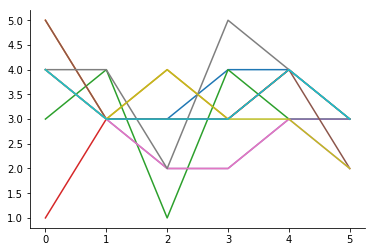

In [12]:
plt.plot(riesling_challenge.iloc[np.argsort(order.values.flatten())].xs("Rating", level=1, axis=1).values)
sns.despine()
plt.show()